# EDA - Datos TCA


### Librerías

In [1]:
import sys
print(sys.executable)


C:\Users\Owner\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe


In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#from sklearn.preprocessing import category_encoders
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
#from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
#sns.set_theme(style="darkgrid")

In [3]:
pd.set_option('display.max_columns', None)

### Conexión a SQL

In [4]:
host = "localhost"  # e.g., 'localhost' or IP address
port = "5432"       # default PostgreSQL port
database = "postgres"
user = "postgres"
password = "equipo3"


In [5]:
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")
#connection = engine.connect()


### Creación de dataframes

In [6]:
df_ocup = pd.read_sql(f"SELECT * FROM ocupaciones", engine)


threshold_zero = 0.9

df_ocup = df_ocup.loc[:, (df_ocup == 0).mean() < threshold_zero]
# Replace empty strings with NaN
df_ocup = df_ocup.replace(r"^\s*$", np.nan, regex=True)



#### Tabla Reservaciones

Contiene detalles de diferentes reservaciones en un periodo de tiempo.

In [16]:
df_resv = pd.read_sql(f"SELECT * FROM reservaciones", engine, index_col='id_reserva')
threshold_zero = 0.9

#df_resv = df_resv.loc[:, (df_resv == 0).mean() < threshold_zero]
# Replace empty strings with NaN
df_resv = df_resv.replace(r"^\s*$", np.nan, regex=True)

# LIMPIEZA DATOS

## Estandarizar fechas

In [17]:
def standardize_date(date_column):
    # Convert column to string to handle different formats
    date_column = date_column.astype(str)
    
    # Convert to datetime: auto-parse for common formats
    date_column = pd.to_datetime(date_column, format=None, errors='coerce')
    
    # Format the column to remove the time part
    return date_column.dt.strftime('%Y-%m-%d')


In [18]:
# Apply the standardization function
df_resv['fecha_hoy'] = standardize_date(df_resv['fecha_hoy'])
df_resv['h_res_fec'] = standardize_date(df_resv['h_res_fec'])
df_resv['h_res_fec_ok'] = standardize_date(df_resv['h_res_fec_ok'])
df_resv['h_fec_lld_ok'] = standardize_date(df_resv['h_fec_lld_ok'])
df_resv['h_fec_reg_ok'] = standardize_date(df_resv['h_res_fec'])
df_resv['h_fec_sda_ok'] = standardize_date(df_resv['h_res_fec_ok'])
df_resv['h_ult_cam_fec_ok'] = standardize_date(df_resv['h_ult_cam_fec_ok'])
df_resv = df_resv.drop(columns=['h_res_fec_okt','h_fec_lld_okt',
                                'h_fec_reg_okt','h_fec_sda_okt',
                               'h_ult_cam_fec_okt'])

df_resv['h_fec_lld'] = df_resv['h_fec_lld'].fillna(0)
df_resv['h_fec_lld'] = df_resv['h_fec_lld'].astype(int).astype(str)

# Step 2: Convert to datetime format
df_resv['h_fec_lld'] = pd.to_datetime(df_resv['h_fec_lld'], format='%Y%m%d', errors='coerce')

# List of columns to convert
date_columns = ['h_res_fec', 'h_fec_sda_ok', 'h_ult_cam_fec_ok', 'fecha_hoy']

# Convert columns to datetime format
for col in date_columns:
    df_resv[col] = pd.to_datetime(df_resv[col], errors='coerce')

## Merge a datos originales de la reservacion

In [19]:
# Function to choose the original if changes were made
def original_if_changed(orig, changed):
    return changed if changed != 0 else orig

# Create new columns by combining original and changed values
for col in ['h_num_per', 'h_num_adu', 'h_num_men', 'h_num_noc', 'h_tot_hab','h_tfa_total','cliente_disp']:
    df_resv[f'{col}'] = df_resv.apply(lambda x: original_if_changed(x[col], x[f'aa_{col}']), axis=1)

# Display the updated DataFrame
#df_resv[['h_num_per', 'h_num_adu', 'h_num_men', 'h_num_noc', 'h_tot_hab']]

## ELIMINACION DE COLUMNAS QUE YA NO NOS SIRVEN

Diferentes columnas contienen la fecha u hora, así como repiten datos.

In [21]:
df_resv = df_resv.drop(columns=['h_nom','h_edo','aa_reservacion','aa_h_num_per','aa_h_num_adu','aa_h_num_men','aa_h_num_noc','aa_h_tot_hab','aa_h_tfa_total','aa_cliente_disp'])


KeyError: "['h_nom', 'h_edo', 'aa_reservacion', 'aa_h_num_per', 'aa_h_num_adu', 'aa_h_num_men', 'aa_h_num_noc', 'aa_h_tot_hab', 'aa_h_tfa_total', 'aa_cliente_disp'] not found in axis"

## fEATURE ENGINEERING

In [33]:
def process_reservations(df_resv):
    """
    Process reservations dataframe (df_resv) to derive features.

    Args:
        df_resv (pd.DataFrame): Reservations dataframe.

    Returns:
        pd.DataFrame: Processed reservations dataframe with new features.
    """
    # Ensure datetime conversion
    df_resv['h_res_fec'] = pd.to_datetime(df_resv['h_res_fec'], errors='coerce')
    df_resv['h_fec_lld'] = pd.to_datetime(df_resv['h_fec_lld'], errors='coerce')
    df_resv['h_fec_lld_ok'] = pd.to_datetime(df_resv['h_fec_lld_ok'], errors='coerce')
    df_resv['h_ult_cam_fec_ok'] = pd.to_datetime(df_resv['h_ult_cam_fec_ok'], errors='coerce')

    # Derived features
    df_resv['days_to_arrival'] = (df_resv['h_fec_lld'] - df_resv['h_res_fec']).dt.days
    df_resv['late_booking'] = (df_resv['days_to_arrival'] <= 3).astype(int)
    df_resv['weekend_arrival'] = df_resv['h_fec_lld'].dt.weekday.isin([5, 6]).astype(int)
    df_resv['reservation_day_of_week'] = df_resv['h_res_fec'].dt.dayofweek
    df_resv['days_btwn_change_arrival'] = abs((df_resv['h_fec_lld_ok'] - df_resv['h_ult_cam_fec_ok']).dt.days)

    # Binary target for no-show
    df_resv['is_no_show'] = ((df_resv['days_btwn_change_arrival'] == 0) & (df_resv['reservacion'] == 0)).astype(int)

    # Additional derived features
    df_resv['month'] = df_resv['h_fec_lld'].dt.month
    df_resv['week_of_year'] = df_resv['h_fec_lld'].dt.isocalendar().week
    df_resv['advanced_booking'] = df_resv['days_to_arrival'] * df_resv['late_booking']

    # Average days to arrival by room type
    avg_days_by_room = df_resv.groupby('id_tipo_habitacion')['days_to_arrival'].mean().to_dict()
    df_resv['avg_days_by_room_type'] = df_resv['id_tipo_habitacion'].map(avg_days_by_room)

    # Rename columns for consistency
    df_resv = df_resv.rename(columns={
        'id_segmento_comp': 'ID_Segmento_Comp',
        'id_tipo_habitacion': 'ID_Tipo_Habitacion'
    })

    return df_resv


In [34]:
df_resv=process_reservations(df_resv)

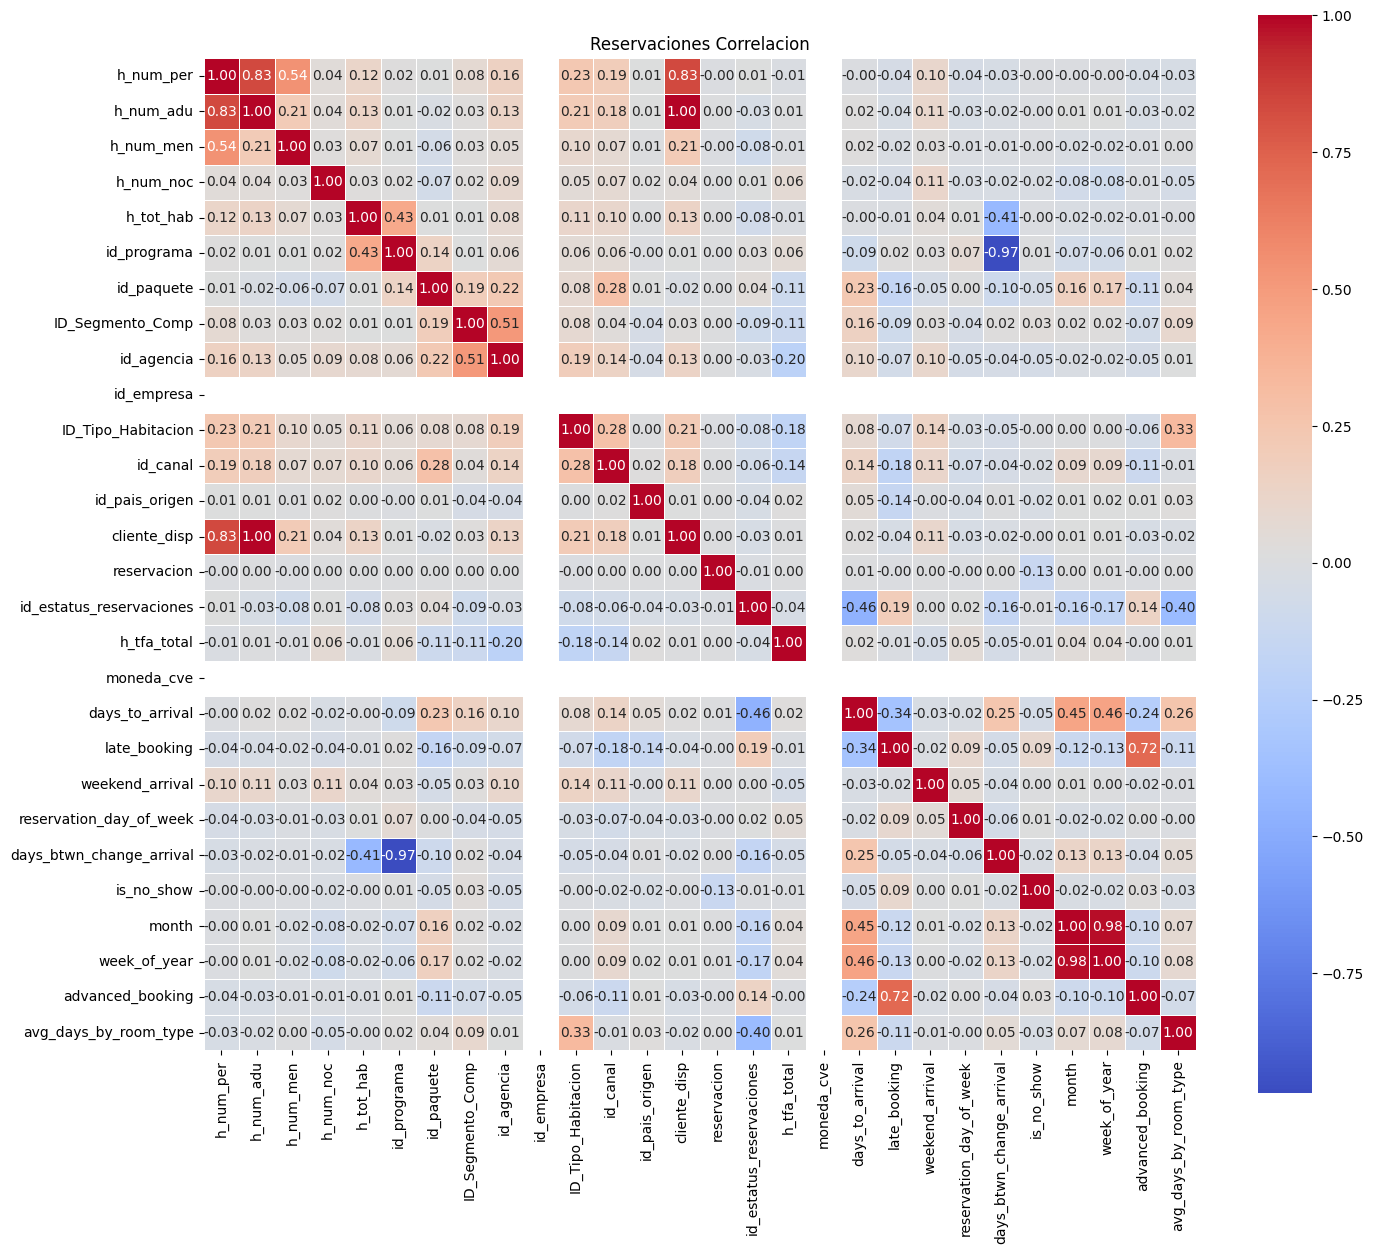

In [35]:
corr_resv = df_resv.corr(numeric_only=True)
plt.figure(figsize=(16, 14))
sns.heatmap(corr_resv, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Reservaciones Correlacion')
plt.show()

# MODELO

### random forest for best features

In [36]:

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Supongamos que df es tu DataFrame

# Mezclar los datos
df_reservaciones = shuffle(df_resv, random_state=42)
drop_columns=['days_btwn_change_arrival','reservacion',
              'is_no_show','fecha_hoy','h_res_fec','h_res_fec_ok','h_fec_lld','h_fec_lld_ok',
              'h_fec_reg_ok','h_fec_sda_ok','h_ult_cam_fec_ok']
# Dividir los datos en conjuntos de entrenamiento y prueba con estratificación
X = df_reservaciones.drop(drop_columns, axis=1)  # Asume que 'reservacion' es tu columna objetivo
y = df_reservaciones['is_no_show']
X = X.dropna()
y = y.loc[X.index]

In [37]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the undersampler
rus = RandomUnderSampler( random_state=42)

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the balance
print(pd.Series(y_resampled).value_counts())  # Outputs the counts of each class to confirm balance

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,  # This should match y_resampled
    random_state=42
)

# Verify class distribution in the train and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Test set class distribution:")
print(y_test.value_counts(normalize=True))

is_no_show
0    2167
1    2167
Name: count, dtype: int64
Training set class distribution:
is_no_show
1    0.500144
0    0.499856
Name: proportion, dtype: float64
Test set class distribution:
is_no_show
0    0.500577
1    0.499423
Name: proportion, dtype: float64


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
])
# Train the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
accuracy = pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8615916955017301


Test Accuracy: 0.8615916955017301
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       434
           1       0.87      0.85      0.86       433

    accuracy                           0.86       867
   macro avg       0.86      0.86      0.86       867
weighted avg       0.86      0.86      0.86       867



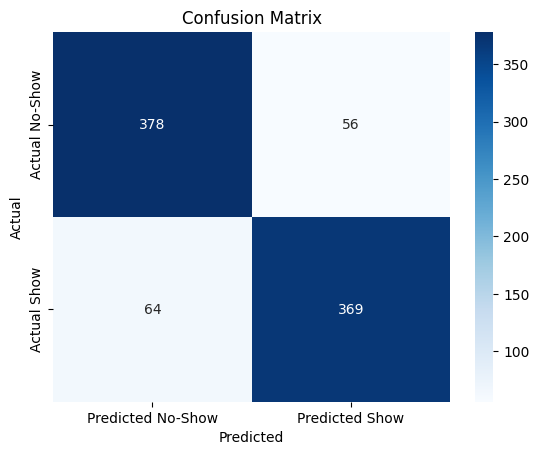

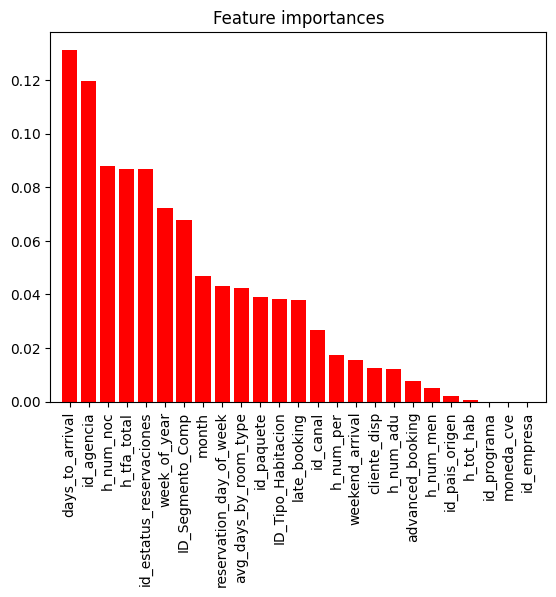

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a fitted pipeline
# Evaluate the pipeline on the test data
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Print the classification report
print(classification_report(y_test, y_pred))

# Generate and display a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted No-Show', 'Predicted Show'], yticklabels=['Actual No-Show', 'Actual Show'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance (for models that support this like RandomForest)
if 'RandomForestClassifier' in str(pipeline.named_steps['classifier']):
    importances = pipeline.named_steps['classifier'].feature_importances_
    features = X_train.columns
    indices = np.argsort(importances)[::-1]
    
    # Plot Feature Importance
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [40]:
selected_features = ['id_estatus_reservaciones','days_to_arrival','late_booking',
                        'reservation_day_of_week','id_paquete','ID_Segmento_Comp','week_of_year', 'h_tfa_total','month','h_num_noc']

categorical_features = ['reservation_day_of_week', 'id_estatus_reservaciones',
                        'late_booking','id_paquete','ID_Segmento_Comp','month',
                        'week_of_year']


numerical_features = ['days_to_arrival', 'h_tfa_total','h_num_noc']

In [41]:
# Pipeline para preprocesar
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Preprocesar los datos
X_preprocessed = preprocessor.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Entrenar modelo
model = RandomForestClassifier(random_state=42,  n_estimators=100, max_depth=10,max_features='sqrt',verbose=1)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.4s


Accuracy: 0.9844827586206897
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     39981
           1       0.00      0.00      0.00       619

    accuracy                           0.98     40600
   macro avg       0.49      0.50      0.50     40600
weighted avg       0.97      0.98      0.98     40600



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


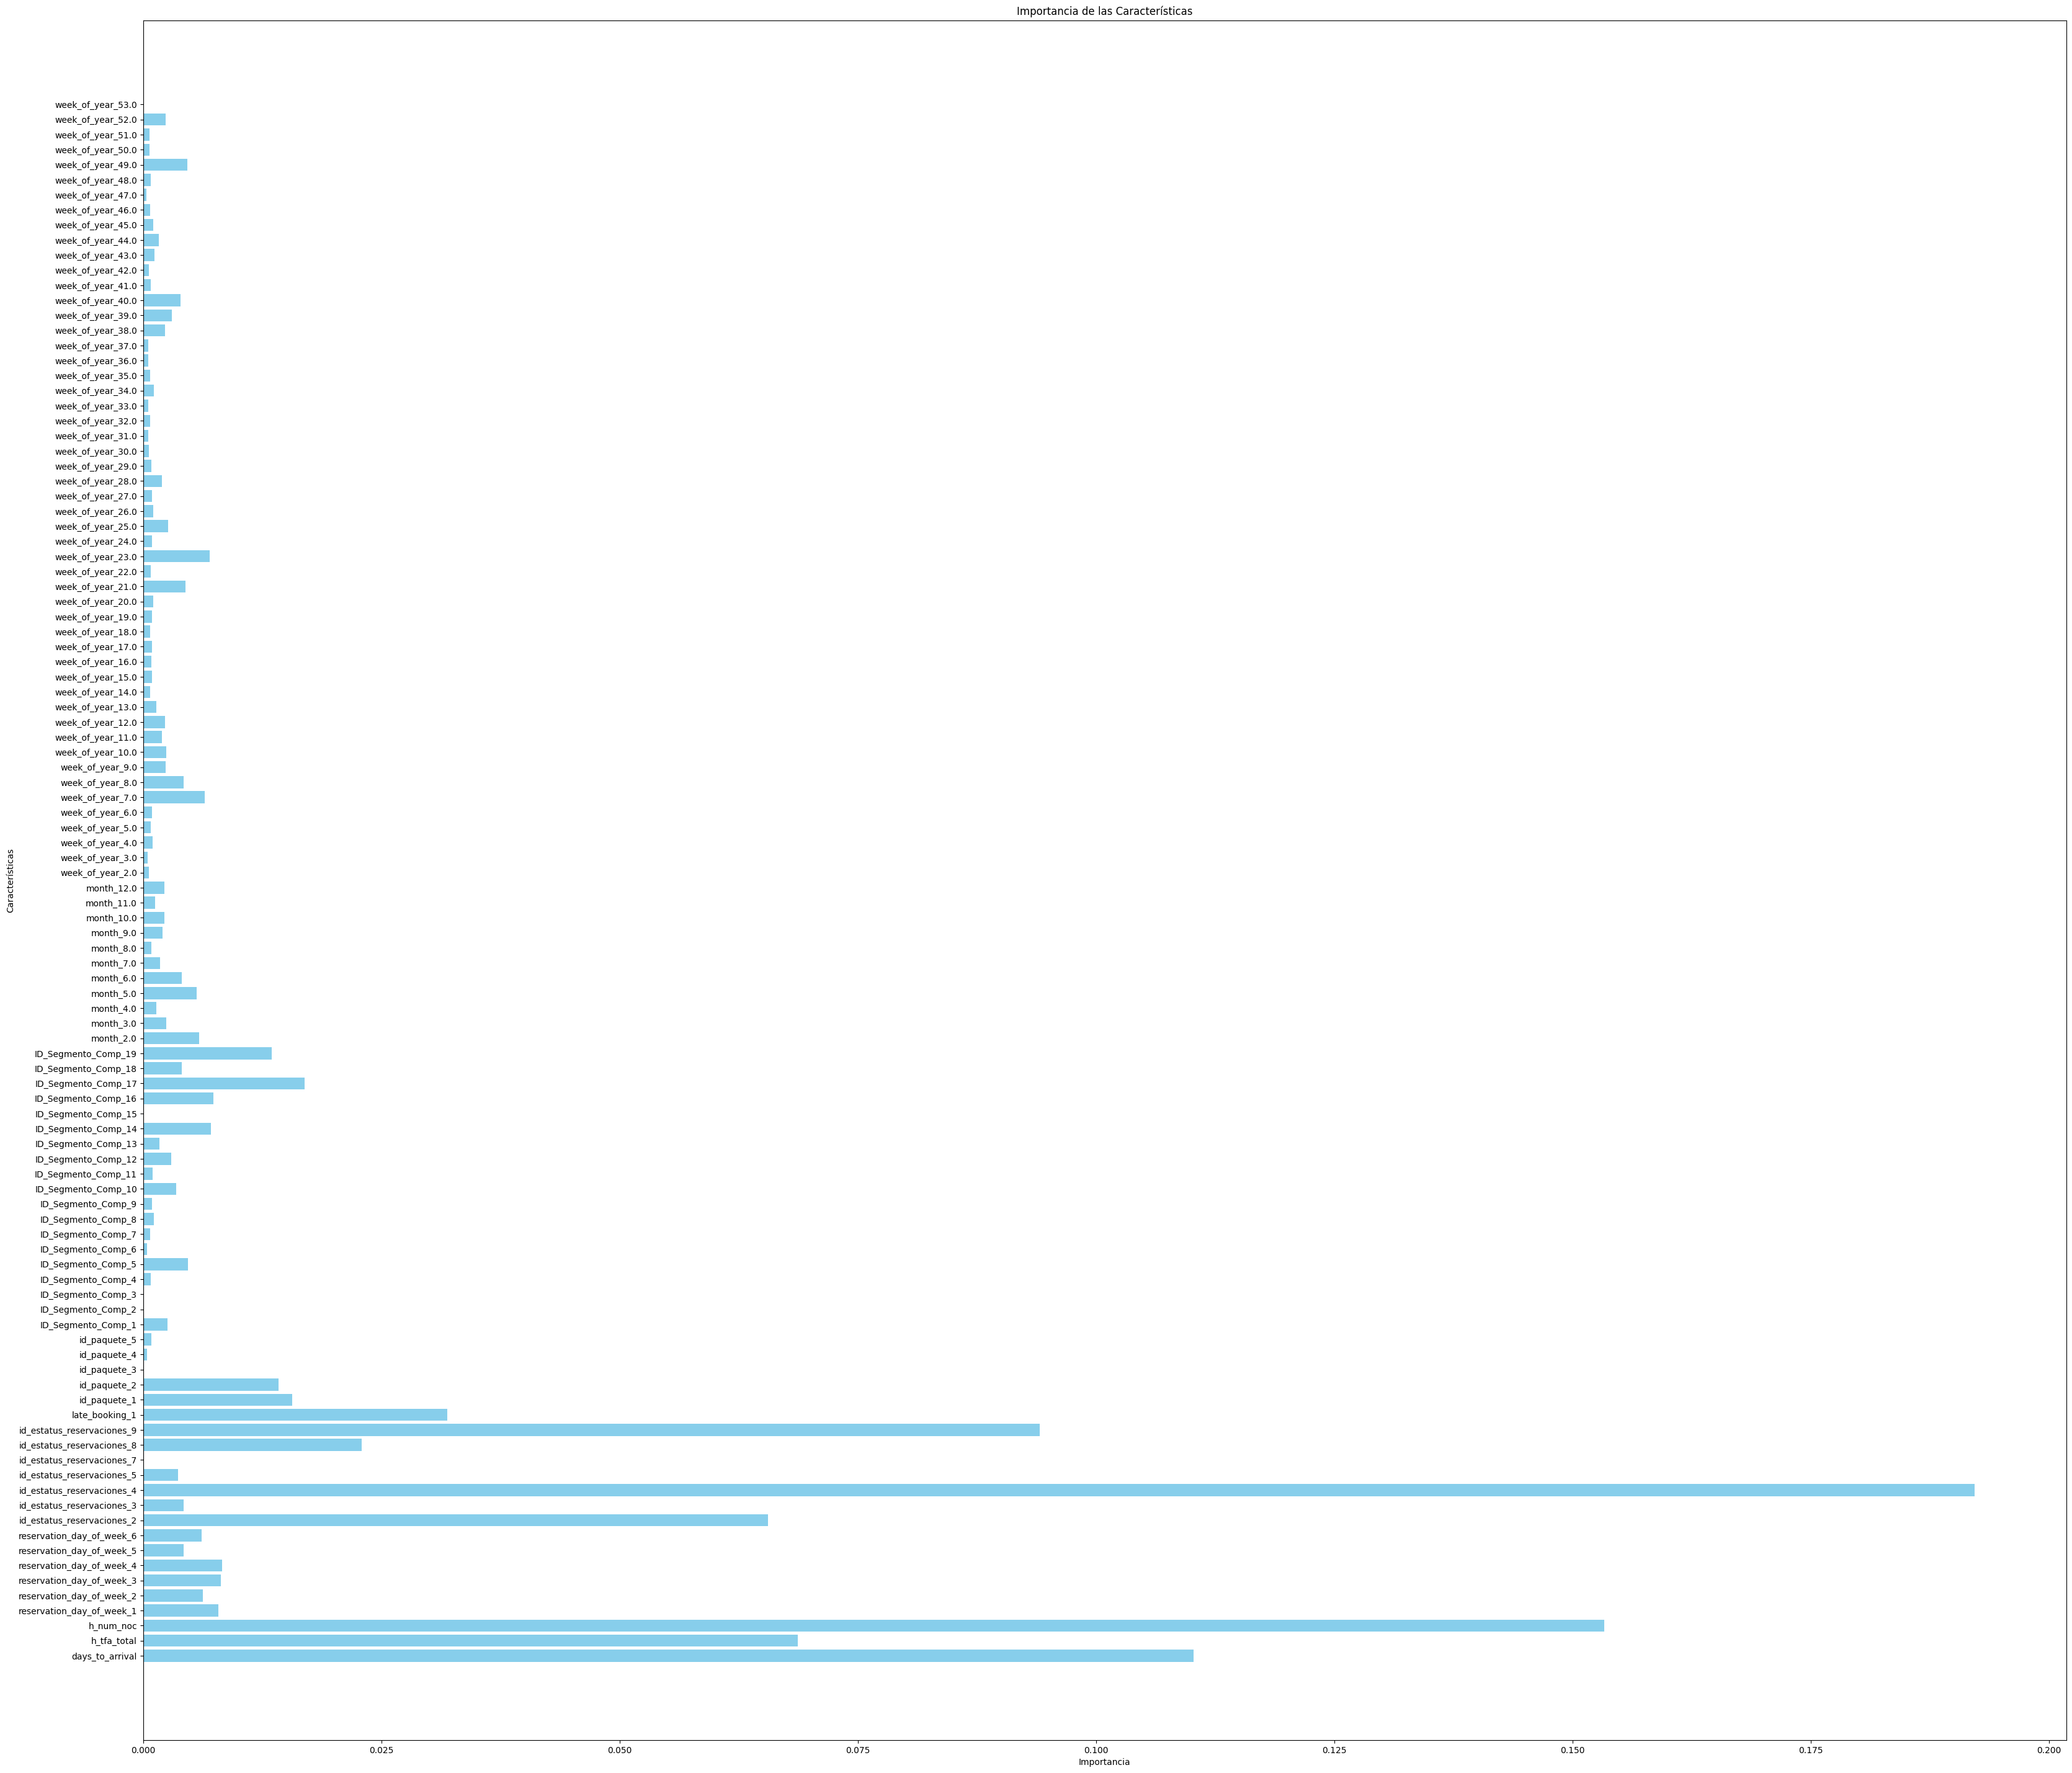

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener importancias de características
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
importances = model.feature_importances_

# Crear gráfico
plt.figure(figsize=(40, 36))
plt.barh(feature_names, importances, color='skyblue')
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

## REDES NEURONALES

In [44]:
df_reservaciones = df_resv

In [45]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Supongamos que df es tu DataFrame

# Mezclar los datos
df_reservaciones = shuffle(df_resv, random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba con estratificación
X = df_reservaciones[['days_to_arrival', 'id_agencia', 'id_estatus_reservaciones','h_num_noc',
                     'h_tfa_total', 'week_of_year','ID_Segmento_Comp', 'reservation_day_of_week','late_booking','h_num_noc']]  # Asume que 'reservacion' es tu columna objetivo
y = df_reservaciones['is_no_show']





In [46]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the undersampler
rus = RandomUnderSampler( random_state=42)

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the balance
print(pd.Series(y_resampled).value_counts())  # Outputs the counts of each class to confirm balance


is_no_show
0    2167
1    2167
Name: count, dtype: int64


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,  # This should match y_resampled
    random_state=42
)

# Verify class distribution in the train and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Test set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
is_no_show
1    0.500144
0    0.499856
Name: proportion, dtype: float64
Test set class distribution:
is_no_show
0    0.500577
1    0.499423
Name: proportion, dtype: float64


In [48]:
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(10, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(20, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(40, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=0.0001)  # Test different rates
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [49]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2)
model.summary()
     

Epoch 1/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4980 - loss: 23.8267 - val_accuracy: 0.4741 - val_loss: 0.7292
Epoch 2/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4952 - loss: 0.7255 - val_accuracy: 0.5317 - val_loss: 0.7389
Epoch 3/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5228 - loss: 0.7076 - val_accuracy: 0.5533 - val_loss: 0.7426
Epoch 4/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5184 - loss: 0.7020 - val_accuracy: 0.4712 - val_loss: 0.7244
Epoch 5/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5164 - loss: 0.7016 - val_accuracy: 0.5735 - val_loss: 0.7113
Epoch 6/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5419 - loss: 0.7081 - val_accuracy: 0.5576 - val_loss: 0.7397
Epoch 7/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5579 - loss: 0.6939 - val_accuracy: 0.5317 - val_loss: 0.6947
Epoch 8/500
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5502 - loss: 0.6941 - val_accuracy: 0.5764 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         1,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,815 (50.06 KB)

 Trainable params: 4,271 (16.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,544 (33.38 KB)

In [50]:
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
Epochs = [i+1 for i in range(len(tr_loss))]
loss_label = f'best epoch= {str(index_loss + 1)}'
val_lowest

0.5398401618003845

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accurcy= 0.7197231833910035


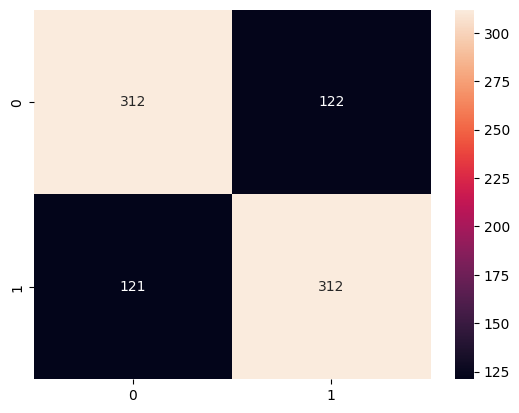

In [51]:
from sklearn.metrics import r2_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)


Accurcy = accuracy_score(y_test, y_pred)
print("Accurcy=",Accurcy )


conf_matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix,annot=True, fmt='d')
plt.show()
     

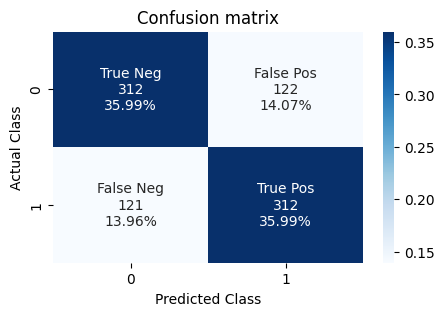

In [52]:
# Define a function to plot the confusion matrix as a heatmap
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2 , v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.subplots(figsize = (5,3))
    ax = sns.heatmap(cm/np.sum(cm), annot=labels, fmt="", cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    ax.set_title(f'Confusion matrix')
    plt.show()
    
    
    
# Plot the confusion matrix as a heatmap
plot_confusion_matrix(y_test, y_pred)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
AUC Score= 0.7889656346782177
Accuracy= 0.7197231833910035


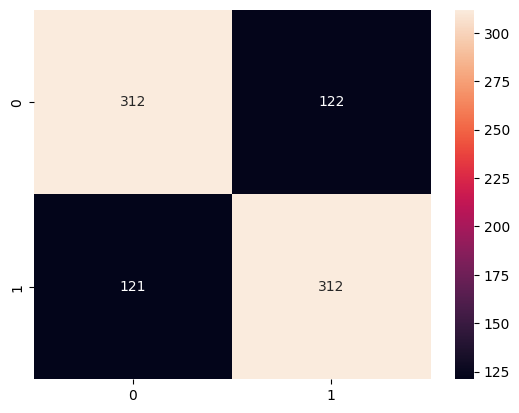

In [53]:
from sklearn.metrics import roc_auc_score

# Use model.predict() to get the prediction probabilities for the positive class
y_probs = model.predict(X_test)  # This assumes the output is the probability of the positive class

# If your model outputs a probability in a different format, adjust indices accordingly
# For example, if it's multi-class classification, you might need to select a specific column:
# y_probs = model.predict(X_test)[:, 1]  # Assuming the second column is for class '1'

# Compute AUC
auc = roc_auc_score(y_test, y_probs)
print("AUC Score=", auc)


Accuracy = accuracy_score(y_test, (y_probs > 0.5).astype(int))
print("Accuracy=", Accuracy)

conf_matrix = confusion_matrix(y_test, (y_probs > 0.5).astype(int))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()


## parameter tuning

In [55]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from kerastuner import Objective
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras.models import Sequential
from keras.layers import Dense

In [59]:
# Define the hypermodel
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_layer1', min_value=8, max_value=64, step=8),
                    activation=hp.Choice('activation_layer1', ['relu', 'tanh'])))
    for i in range(hp.Int('num_layers', 1, 4)):  # Tune the number of layers
        model.add(Dense(hp.Int(f'units_layer{i+2}', min_value=8, max_value=64, step=8),
                        activation=hp.Choice(f'activation_layer{i+2}', ['relu', 'tanh'])))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='tuning_results',
    project_name='tune_nn'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=250, validation_split=0.2, verbose=1)


Reloading Tuner from tuning_results\tune_nn\tuner0.json


In [60]:
# Retrieve the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model using the retrieved hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Compile the model (if not automatically compiled by Keras Tuner)
best_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = best_model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5304 - loss: 87.1404 - val_accuracy: 0.5476 - val_loss: 9.2228
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5455 - loss: 7.0722 - val_accuracy: 0.6081 - val_loss: 2.0049
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5712 - loss: 3.6631 - val_accuracy: 0.5303 - val_loss: 15.2608
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5499 - loss: 13.6235 - val_accuracy: 0.5072 - val_loss: 5.6249
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5545 - loss: 5.0858 - val_accuracy: 0.5043 - val_loss: 8.8442
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5440 - loss: 8.1765 - val_accuracy: 0.6297 - val_loss: 2.3334
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6212 - loss: 3.1072 - val_accuracy: 0.6787 - val_loss: 0.9018
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5417 - loss: 8.6082 - val_accuracy: 0.5519 

In [61]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")


Best hyperparameters:
units_layer1: 56
activation_layer1: relu
num_layers: 1
units_layer2: 64
activation_layer2: relu
optimizer: adam
units_layer3: 32
activation_layer3: tanh
units_layer4: 40
activation_layer4: tanh


In [62]:
est_model = tuner.hypermodel.build(best_hps)

# Compile the model again (if not already compiled)
best_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the best model
history = best_model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6038 - loss: 5.5009 - val_accuracy: 0.6138 - val_loss: 1.6592
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6016 - loss: 2.3131 - val_accuracy: 0.6801 - val_loss: 0.9456
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6467 - loss: 1.5462 - val_accuracy: 0.5980 - val_loss: 2.0512
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6642 - loss: 1.5654 - val_accuracy: 0.5908 - val_loss: 2.4020
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6921 - loss: 1.1402 - val_accuracy: 0.5274 - val_loss: 5.0385
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6185 - loss: 2.7494 - val_accuracy: 0.6499 - val_loss: 2.1261
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6801 - loss: 1.2559 - val_accuracy: 0.6138 - val_loss: 1.9595
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6500 - loss: 1.9820 - val_accuracy: 0.7378 - v

In [63]:
from sklearn.metrics import roc_auc_score

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get the predicted probabilities for the positive class
y_probs = best_model.predict(X_test)  # Returns probabilities for the positive class

# Compute the AUC score
auc = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.7322 - loss: 0.7076
Test Loss: 0.6458401083946228
Test Accuracy: 0.7439446449279785
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC Score: 0.7926187460754993


In [64]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (y_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.75       434
           1       0.77      0.70      0.73       433

    accuracy                           0.74       867
   macro avg       0.75      0.74      0.74       867
weighted avg       0.75      0.74      0.74       867

Confusion Matrix:
 [[341  93]
 [129 304]]
